# Modeling spike data with `multidms.jaxmodels`

In [1]:
import multidms
import multidms.jaxmodels

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

Papermill params

In [2]:
replicate = "lib_1"
func_score_type = "loose_bottle"
do_truncate_nonsense = True
output_dir = 'simulations_output'

reference = 'h1'
l2reg = 1e-4
fusionreg = 1e0
block_iters = 50
block_tol = 0

ge_tol = 1e-4
ge_maxiter = 1000
ge_maxls = 30

cal_tol = 1e-4
cal_maxiter = 1000
cal_maxls = 30

loss_fn = "functional_score_loss"
# loss_fn = "count_loss"

loss_kwargs = {"δ": 1.0}
# loss_kwargs = {}

# global_epistasis = "Identity"
global_epistasis = "Sigmoid"

functional_score_min = -2
functional_score_max = 1
pseudocount = 0.
min_pre_count = 200
min_post_count = 1

In [3]:
loss_fn = getattr(multidms.jaxmodels, loss_fn)
global_epistasis = getattr(multidms.jaxmodels, global_epistasis)()

In [4]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Data loading/filtering

Read raw data, pick replicate, and aggregate counts

In [5]:
df = pd.read_csv("simulated_bottleneck_cbf.csv", keep_default_na=False)
df.rename(
    columns={
        "library": "replicate",
        "homolog": "condition",
        "n_aa_substitutions": "n_subs",
    },
    inplace=True,
)

<Axes: >

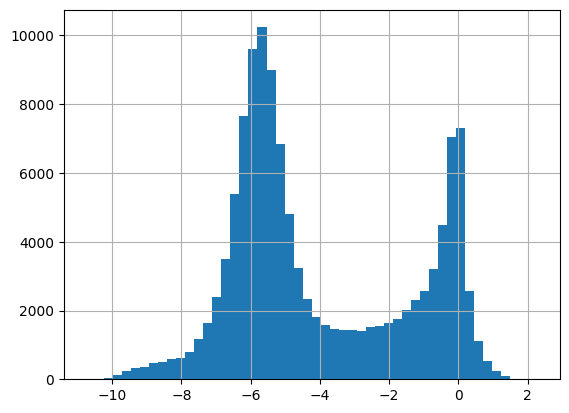

In [6]:
df.func_score.hist(bins=50)

In [7]:
df

,replicate,pre_sample,func_score_type,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_subs,condition
0,lib_1,pre-selection,loose_bottle,Q28P,-0.021369,0.001590,1882,4339,697073,1630857,0.5,1,h1
1,lib_1,pre-selection,loose_bottle,G50E,-0.067491,0.002172,1390,3104,697073,1630857,0.5,1,h1
2,lib_1,pre-selection,loose_bottle,R48G,-1.291522,0.002221,1921,1836,697073,1630857,0.5,1,h1
3,lib_1,pre-selection,loose_bottle,S3R G10Y L49H,-5.759732,0.068933,729,31,697073,1630857,0.5,3,h1
4,lib_1,pre-selection,loose_bottle,F18T Q21E C44T,-5.313711,0.051858,722,42,697073,1630857,0.5,3,h1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120907,lib_2,pre-selection,tight_bottle,E9L Q21L V24Q S25V D29V D38Q,-3.857460,0.934082,20,2,859800,1519830,0.5,6,h2
120908,lib_2,pre-selection,tight_bottle,S47T V49E,-6.107239,4.269479,19,0,859800,1519830,0.5,2,h2
120909,lib_2,pre-selection,tight_bottle,G10P I35S G50L,-4.366157,1.506518,17,1,859800,1519830,0.5,3,h2
120910,lib_2,pre-selection,tight_bottle,F15R I35S D38E Y39G,-5.776033,4.297024,15,0,859800,1519830,0.5,4,h2


In [8]:
df.query(f"replicate == '{replicate}' & func_score_type == '{func_score_type}'", inplace=True)
df

,replicate,pre_sample,func_score_type,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_subs,condition
0,lib_1,pre-selection,loose_bottle,Q28P,-0.021369,0.001590,1882,4339,697073,1630857,0.5,1,h1
1,lib_1,pre-selection,loose_bottle,G50E,-0.067491,0.002172,1390,3104,697073,1630857,0.5,1,h1
2,lib_1,pre-selection,loose_bottle,R48G,-1.291522,0.002221,1921,1836,697073,1630857,0.5,1,h1
3,lib_1,pre-selection,loose_bottle,S3R G10Y L49H,-5.759732,0.068933,729,31,697073,1630857,0.5,3,h1
4,lib_1,pre-selection,loose_bottle,F18T Q21E C44T,-5.313711,0.051858,722,42,697073,1630857,0.5,3,h1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75503,lib_1,pre-selection,loose_bottle,S5R G6K V24P,-4.891251,1.476152,23,1,868363,1644895,0.5,3,h2
75504,lib_1,pre-selection,loose_bottle,F4S V11P V19P E44*,-4.828516,1.480088,22,1,868363,1644895,0.5,4,h2
75505,lib_1,pre-selection,loose_bottle,S3C Q28V D32V T36* L46T,-6.413478,4.255247,22,0,868363,1644895,0.5,5,h2
75506,lib_1,pre-selection,loose_bottle,G1P S2V G6I C34V I35E E44R,-5.313942,4.360967,10,0,868363,1644895,0.5,6,h2


In [9]:

# remove variants with too many deletions
df = df.loc[df.aa_substitutions.str.count("-") == 0, :]

df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
    {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
    ).reset_index()

df

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,h1,lib_1,,0,697073,1630857
1,h1,lib_1,C31*,1,930,35
2,h1,lib_1,C31* C44K,2,98,4
3,h1,lib_1,C31* F40T S47D L49A,4,142,7
4,h1,lib_1,C31* H33Y G50T,3,109,4
...,...,...,...,...,...,...
30235,h2,lib_1,Y39V G50T,2,331,543
30236,h2,lib_1,Y39V V43F,2,312,575
30237,h2,lib_1,Y39W,1,1514,214
30238,h2,lib_1,Y39W S47*,2,136,6


In [10]:
df.query("aa_substitutions == ''")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
0,h1,lib_1,,0,697073,1630857
15096,h2,lib_1,,0,868363,1644895


In [11]:
df[df["aa_substitutions"].str.contains("G50W")]

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count
2413,h1,lib_1,F4R S9N V11* Q21R H27* H33F G50W,7,135,5
4099,h1,lib_1,G50W,1,98,269
18182,h2,lib_1,F4R E9N V11* Q21R H27* H33F G50W,7,192,8
19809,h2,lib_1,G50W,1,131,266


Ah, G50W doesn't hit the threshold.

### Count filtering

Apply some thresholds to filter out low counts. We need pre-counts to be reasonably high to satisfy assumptions of the count-based loss function.

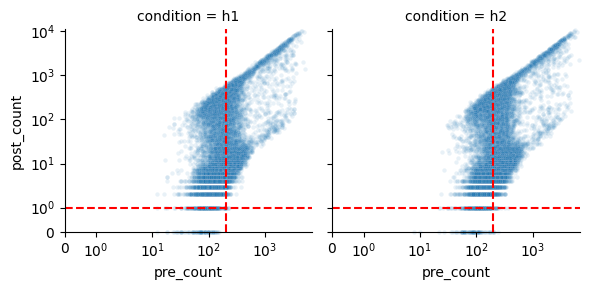

In [12]:
g = sns.relplot(
    x=df.pre_count[df.aa_substitutions != ""],
    y=df.post_count[df.aa_substitutions != ""],
    col=df.condition[df.aa_substitutions != ""],
    s=10, alpha=0.1,
    height=3, aspect=1,
    clip_on=False,
    )
plt.xlim(0, None)
plt.ylim(0, None)
plt.xscale("symlog", linthresh=1, linscale=0.5)
plt.yscale("symlog", linthresh=1, linscale=0.5)

for ax in g.axes.flat:
    condition = ax.get_title().split(" = ")[1]
    df_condition = df.query(f"(condition == @condition) & (aa_substitutions != '')")
    df.drop(index=df_condition.query("(pre_count < @min_pre_count) | (post_count < @min_post_count)").index, inplace=True)
    ax.axvline(min_pre_count, color="red", linestyle="--")
    ax.axhline(min_post_count, color="red", linestyle="--")

plt.tight_layout()
plt.show()

In [13]:
df.shape

(15930, 6)

### Mutation number filtering

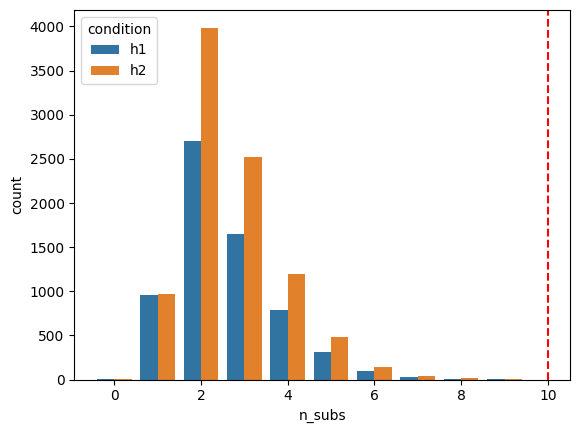

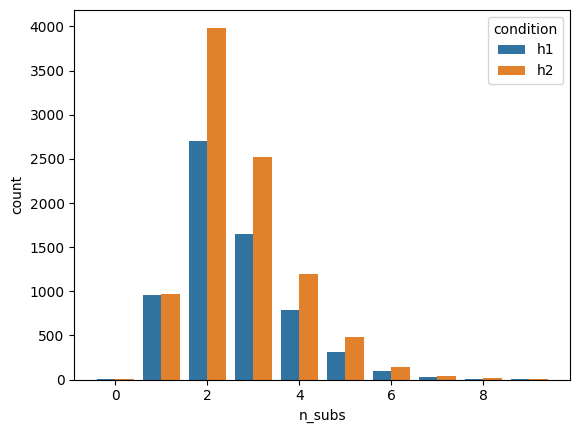

In [14]:
n_sub_thresh = 10

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.axvline(n_sub_thresh, color="red", linestyle="--")
plt.show()

df = df.query("n_subs <= @n_sub_thresh")

sns.countplot(data=df, x="n_subs", hue="condition", native_scale=True)
plt.show()


In [15]:
df.shape

(15930, 6)

### Nonsense variants

Truncate nonsense variants to exlude any mutations downstream of the first nonsense mutation, and then filter to only nonsense variants with no missense mutation before first nonsense.

In [16]:
# # TEMP: cmopletetely remove nonsense
# df = df.loc[~df.aa_substitutions.str.contains("*", regex=False)]
# df.shape

In [17]:
def truncate_nonsense(row):
    if row.aa_substitutions:
        muts = row.aa_substitutions.split(" ")
        assert len(muts) == row.n_subs, row
        new_muts = []
        for mut in muts:
            new_muts.append(mut)
            if "*" in mut:
                break
        row.aa_substitutions = " ".join(new_muts)
        row.n_subs = len(new_muts)
    return row

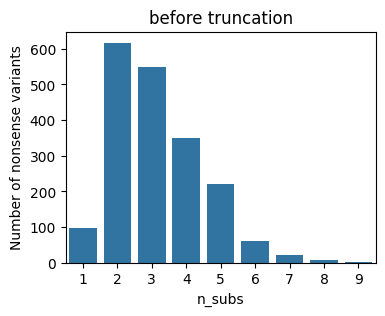

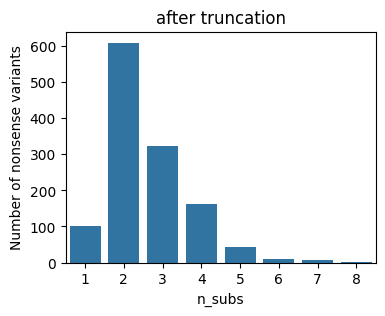

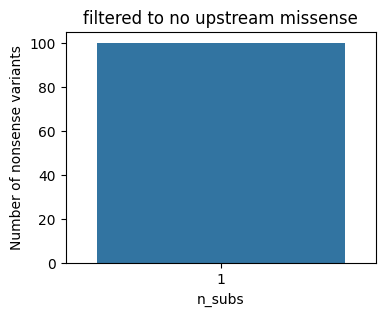

In [18]:
plt.figure(figsize=(4, 3))
sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
plt.ylabel("Number of nonsense variants")
plt.title("before truncation")
plt.show()

if do_truncate_nonsense:
    df = df.apply(truncate_nonsense, axis=1)
    # re-aggregate identical variants
    df = df.groupby(["condition", "replicate", "aa_substitutions"]).agg(
        {"n_subs": "first", "pre_count": "sum", "post_count": "sum"}
        ).reset_index()

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("after truncation")
    plt.show()

    df = df.loc[~(df.aa_substitutions.str.contains("*", regex=False) & (df.n_subs > 1)), :]

    plt.figure(figsize=(4, 3))
    sns.countplot(x=df.loc[df.aa_substitutions.str.contains("*", regex=False)].n_subs)
    plt.ylabel("Number of nonsense variants")
    plt.title("filtered to no upstream missense")
    plt.show()

### Compute functional scores

Note: $\log$ is more natural than $\log_2$ in the fitness-based model

/var/folders/3x/xgx592cd1036yjqqj8dnvnsh0000gn/T/ipykernel_15266/2872106849.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)


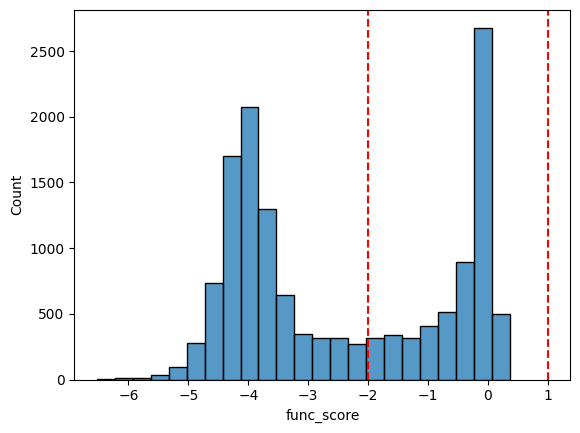

In [19]:
df["func_score"] = np.log(df["post_count"] + pseudocount) - np.log(df["pre_count"] + pseudocount)

def group_wt_ref(df_group):
    wts = df_group.query("aa_substitutions == ''")
    assert wts.shape[0] == 1, wts
    df_group.func_score = df_group.func_score.values - wts.func_score.values[0]
    return df_group

df = df.groupby(["condition", "replicate"]).apply(group_wt_ref, include_groups=False).reset_index(level=-1, drop=True).reset_index()

sns.histplot(df.func_score)
plt.axvline(functional_score_min, color="red", linestyle="--")
plt.axvline(functional_score_max, color="red", linestyle="--")
df.func_score.clip(lower=functional_score_min, upper=functional_score_max, inplace=True)
plt.show()

<Axes: xlabel='func_score', ylabel='Count'>

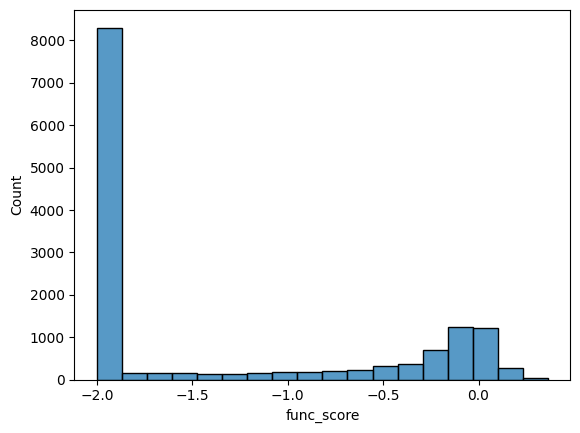

In [20]:
sns.histplot(df.func_score)

In [21]:
df.shape

(14109, 7)

In [22]:
# how many unique mutations are seen in the dataset? Note that we need to split the space-separated strings in the aa_substitutions column and then explode the list into separate rows to count unique mutations.
df.aa_substitutions.str.split(" ").explode().nunique()

1200

In [23]:
50 * 20

1000

In [24]:
10 * 20

200

In [25]:
# check that G50W exists in the dataset
df[df["aa_substitutions"].str.contains("G50W")]

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score


### Multidms data

Load as a multidms dataset, choosing a reference condition.

In [26]:
multidms_data = multidms.Data(
    df,
    alphabet=multidms.AAS_WITHSTOP_WITHGAP,
    reference=reference,
)

/Users/macdre/Matsengrp/projects/dms/.pixi/envs/default/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [27]:
# BA2_numbering = pd.read_csv("https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_Omicron_BA.2_spike_DMS/main/results/site_numbering/site_numbering_map.csv", index_col="reference_site")
# BA2_numbering


# foo = multidms_data.site_map.join(BA2_numbering)

# bad_idxs = foo.Omicron_BA2 != foo.sequential_wt

# foo.loc[bad_idxs, :]

# # BA2_numbering.loc[BA2_numbering.sequential_wt != BA2_numbering.reference_wt, :]

Create a `jaxmodels.Data` object, containing the array data

In [28]:
data_sets = {
    d: multidms.jaxmodels.Data.from_multidms(multidms_data, d)
    for d in multidms_data.conditions
    }

# Display the reference condition data object
data_sets[multidms_data.reference]

Data(
  x_wt=i8[999],
  pre_count_wt=i64[],
  post_count_wt=i64[],
  X=BCOO(int8[5844, 999], nse=14600),
  pre_counts=i64[5844],
  post_counts=i64[5844],
  functional_scores=f64[5844]
)

In [29]:
data_sets

{'h1': Data(
   x_wt=i8[999],
   pre_count_wt=i64[],
   post_count_wt=i64[],
   X=BCOO(int8[5844, 999], nse=14600),
   pre_counts=i64[5844],
   post_counts=i64[5844],
   functional_scores=f64[5844]
 ),
 'h2': Data(
   x_wt=i8[999],
   pre_count_wt=i64[],
   post_count_wt=i64[],
   X=BCOO(int8[8263, 999], nse=99521),
   pre_counts=i64[8263],
   post_counts=i64[8263],
   functional_scores=f64[8263]
 )}

In [30]:
df.query("aa_substitutions == ''    ")

,condition,replicate,aa_substitutions,n_subs,pre_count,post_count,func_score
0,h1,lib_1,,0,697073,1630857,0.0
5845,h2,lib_1,,0,868363,1644895,0.0


In [31]:
for condition in multidms_data.conditions:
    print(data_sets[condition].pre_count_wt)
    print(data_sets[condition].post_count_wt)


697073
1630857
868363
1644895


# WARNING: random samples for testing if uncommented

In [32]:
# data_sets_OLD = data_sets

In [33]:
# import jax

# data_sets = {}

# for d in multidms_data.conditions:
#     # sample_slice = slice(0, len(data_sets_OLD[d].X) // 2)
#     sample_slice = slice(len(data_sets_OLD[d].X) // 2 + 1, None)
#     data_sets[d] = multidms.jaxmodels.Data(
#         data_sets_OLD[d].x_wt,
#         data_sets_OLD[d].pre_count_wt,
#         data_sets_OLD[d].post_count_wt,
#         jax.experimental.sparse.BCOO.fromdense(data_sets_OLD[d].X[sample_slice].todense()),
#         data_sets_OLD[d].pre_counts[sample_slice],
#         data_sets_OLD[d].post_counts[sample_slice],
#         data_sets_OLD[d].functional_scores[sample_slice],
#     )
#     assert (data_sets_OLD[d].X[sample_slice].todense() == data_sets[d].X.todense()).all(), f"Data mismatch for condition {d}: {data_sets_OLD[d].X[sample_slice]} and {data_sets[d].X}"



In [34]:
{d: int(data_sets[d].x_wt.sum()) for d in data_sets}

# {'Delta': 30, 'Omicron_BA1': 0, 'Omicron_BA2': 14}

{'h1': 0, 'h2': 10}

Plot the sums of the binary encodings of the variants

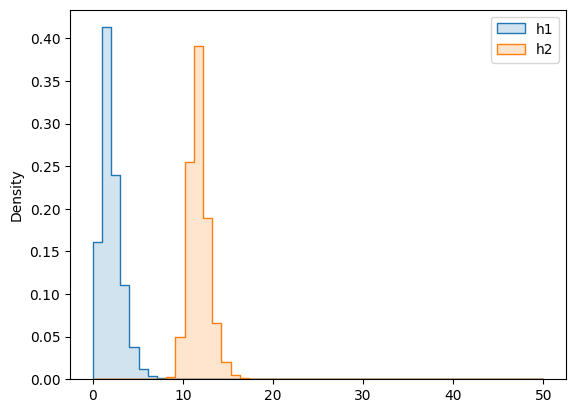

In [35]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.X.sum(1, dtype=float).todense(), label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(0, 50, 50), stat="density")
plt.legend()
plt.show()

Distribution of functional scores

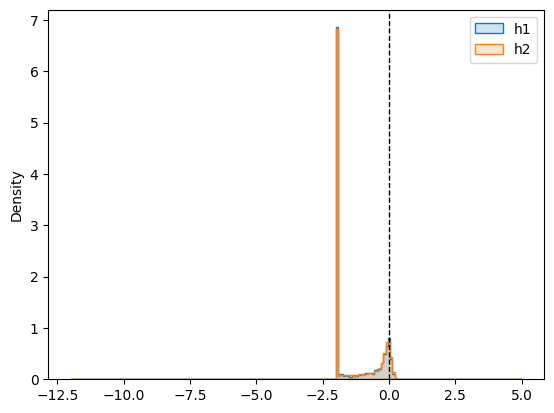

In [36]:
for d, data_set in data_sets.items():
    sns.histplot(x=data_set.functional_scores, label=d, fill=True, alpha=0.2, element="step", bins=np.linspace(-12, 5, 200), stat="density")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.legend()
plt.show()

## Fit model

In [37]:
model, loss_trajectory = multidms.jaxmodels.fit(
    data_sets,
    multidms_data.reference,
    l2reg=l2reg,
    fusionreg=fusionreg,
    block_iters=block_iters,
    block_tol=block_tol,
    ge_kwargs=dict(
        tol=ge_tol,
        maxiter=ge_maxiter,
        maxls=ge_maxls,
        jit=True,
        # verbose=False
        ),
    cal_kwargs=dict(
        tol=cal_tol,
        maxiter=cal_maxiter,
        maxls=cal_maxls,
        jit=True,
        # verbose=False
        ),
    loss_fn=loss_fn,
    global_epistasis=global_epistasis,
    loss_kwargs=loss_kwargs,
    )

iter 1:
  calibration block: error=6.05e-05, stepsize=6.4e+01, iter=17
    h1: α=8.77, θ=1.00
    h2: α=8.67, θ=1.00
  β0 block: error=3.47e-05, stepsize=4.0e+00, iter=4
    h1: β0=-0.59
    h2: β0=0.43
  β_bundle: error=6.83e-05, stepsize=2.0e+00, iter=907
  β_nonbundle: error=7.53e-05, stepsize=5.1e+02, iter=38
  h2 sparsity=35.6%
  obj=9.27e-02
  objective_error=9.07e-01
iter 2:
  calibration block: error=2.17e-05, stepsize=6.4e+01, iter=12
    h1: α=8.40, θ=1.00
    h2: α=8.24, θ=1.00
  β0 block: error=4.26e-05, stepsize=4.0e+00, iter=5
    h1: β0=-0.62
    h2: β0=0.40
  β_bundle: error=9.08e-05, stepsize=1.0e+00, iter=516
  β_nonbundle: error=7.31e-05, stepsize=5.1e+02, iter=37
  h2 sparsity=38.8%
  obj=8.42e-02
  objective_error=8.57e-03
iter 3:
  calibration block: error=5.74e-05, stepsize=6.4e+01, iter=11
    h1: α=8.04, θ=1.00
    h2: α=7.82, θ=1.00
  β0 block: error=4.37e-05, stepsize=4.0e+00, iter=5
    h1: β0=-0.64
    h2: β0=0.38
  β_bundle: error=7.35e-05, stepsize=1.0e+0

## Loss trajectory

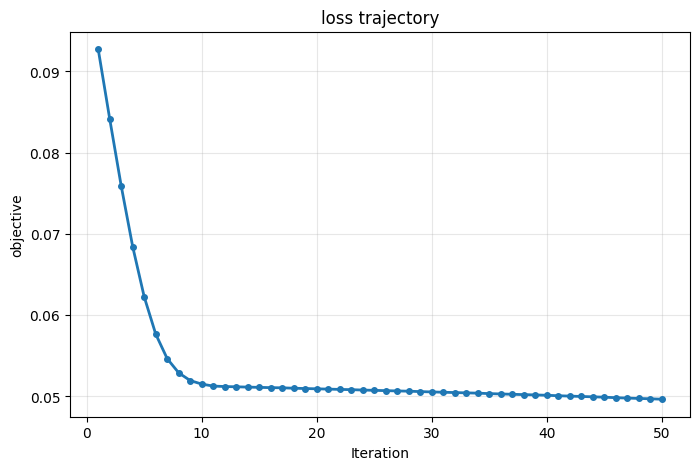

Final loss: 0.049659
Total iterations: 50


In [38]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_trajectory) + 1), loss_trajectory, 'o-', linewidth=2, markersize=4)
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title('loss trajectory')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {loss_trajectory[-1]:.6f}")
print(f"Total iterations: {len(loss_trajectory)}")


$\beta$ shift distributions

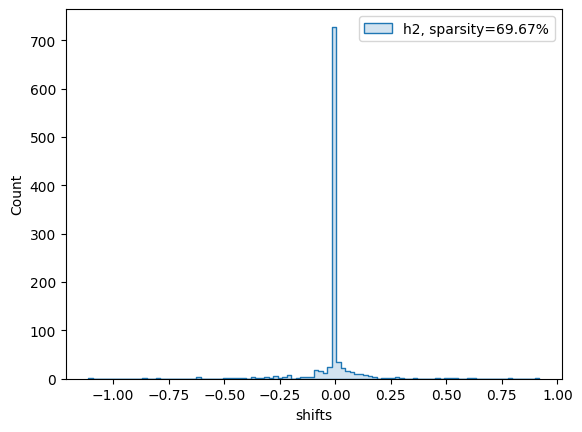

In [39]:
for d in data_sets:
    if d != model.reference_condition:
        shifts = model.φ[d].β - model.φ[model.reference_condition].β
        sns.histplot(
            x=shifts,
            bins=100,
            label=f"{d}, sparsity={(shifts == 0).sum() / len(shifts):.2%}", fill=True, alpha=0.2, element="step")
plt.legend()
plt.xlabel("shifts")
plt.show()

Read in ground truth mut effects

In [102]:
simu_mut_effects = pd.read_csv("simulated_muteffects.csv", keep_default_na=False)
simu_mut_effects

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,G1A,-2.981264,G,1,A,False,0.0,-2.981264,G,G,False
1,G1C,-5.609745,G,1,C,False,0.0,-5.609745,G,G,False
2,G1D,-0.751102,G,1,D,False,0.0,-0.751102,G,G,False
3,G1E,-5.157105,G,1,E,False,0.0,-5.157105,G,G,False
4,G1F,-1.019324,G,1,F,False,0.0,-1.019324,G,G,False
...,...,...,...,...,...,...,...,...,...,...,...
995,G50T,1.934619,G,50,T,False,0.0,1.934619,G,G,False
996,G50V,-1.888492,G,50,V,False,0.0,-1.888492,G,G,False
997,G50W,1.070726,G,50,W,False,0.0,1.070726,G,G,False
998,G50Y,-9.847493,G,50,Y,False,0.0,-9.847493,G,G,False


Find ground truth sparsity

In [103]:
# how many shifts are equal to zero in simulated mut effects
zero_shift_df = simu_mut_effects[simu_mut_effects["shift"] == 0]
display(zero_shift_df)
(zero_shift_df.shape[0], simu_mut_effects.shape[0], zero_shift_df.shape[0] / simu_mut_effects.shape[0])

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
0,G1A,-2.981264,G,1,A,False,0.0,-2.981264,G,G,False
1,G1C,-5.609745,G,1,C,False,0.0,-5.609745,G,G,False
2,G1D,-0.751102,G,1,D,False,0.0,-0.751102,G,G,False
3,G1E,-5.157105,G,1,E,False,0.0,-5.157105,G,G,False
4,G1F,-1.019324,G,1,F,False,0.0,-1.019324,G,G,False
...,...,...,...,...,...,...,...,...,...,...,...
995,G50T,1.934619,G,50,T,False,0.0,1.934619,G,G,False
996,G50V,-1.888492,G,50,V,False,0.0,-1.888492,G,G,False
997,G50W,1.070726,G,50,W,False,0.0,1.070726,G,G,False
998,G50Y,-9.847493,G,50,Y,False,0.0,-9.847493,G,G,False


(810, 1000, 0.81)

Functional score correlations

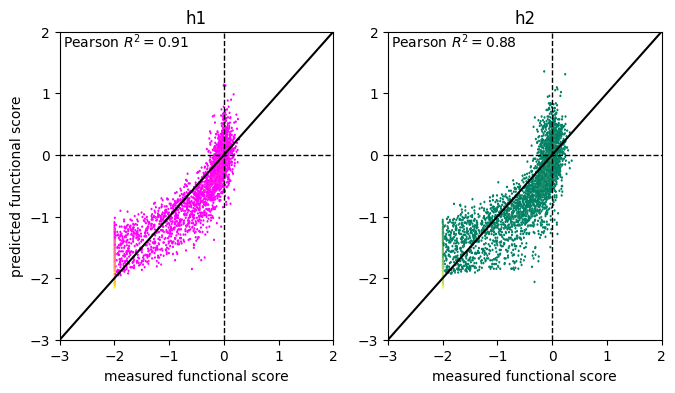

In [104]:
y_preds = model.predict_score(data_sets)

plt.figure(figsize=(12, 4))
ax = None
cmaps = ["spring", "summer", "autumn"]
colors = ["magenta", "green", "red"]
for i, (d, data_set) in enumerate(data_sets.items()):

    X = data_set.X
    x_wt = data_set.x_wt
    y = data_set.functional_scores
    y_pred = y_preds[d]

    ax = plt.subplot(1, 3, i + 1, sharex=ax, sharey=ax)
    plt.hexbin(y, y_pred, cmap=cmaps[i], gridsize=200, bins="log")
    # plt.scatter(y, y_pred, c=colors[i], s=0.1, alpha=0.5)
    plt.annotate(f"Pearson $R^2={scipy.stats.pearsonr(y, y_pred).statistic**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-10, 4], [-10, 4], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    plt.xlim(-3, 2)
    plt.ylim(-3, 2)
    plt.xlabel("measured functional score")
    if i == 0:
        plt.ylabel("predicted functional score")
    plt.title(d)

plt.show()

Fitness landscape

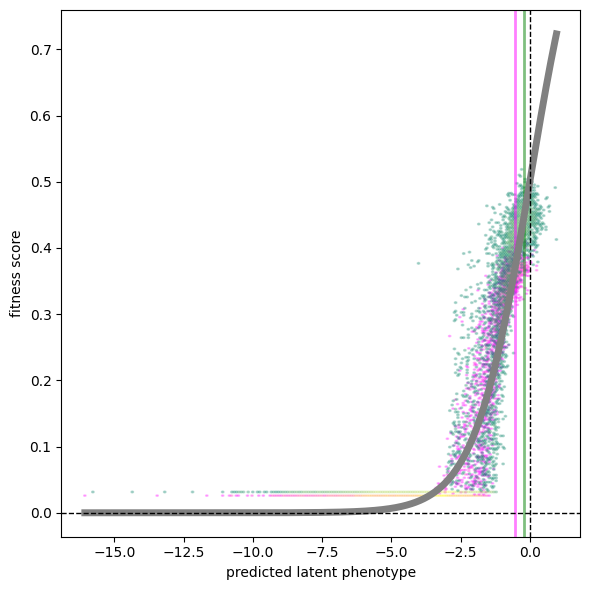

In [105]:
plt.figure(figsize=(6, 6))
φ_min = np.inf
φ_max = -np.inf
for i, (d, data_set) in enumerate(data_sets.items()):
    X = data_set.X
    x_wt = data_set.x_wt
    φ = model.φ[d]
    α = model.α[d]
    φ_pred = φ(X)
    φ_min = min(φ_min, φ_pred.min())
    φ_max = max(φ_max, φ_pred.max())
    φ_pred_wt = φ(x_wt)
    y = data_set.functional_scores
    f = y / α + model.global_epistasis(φ(x_wt))
    # plt.scatter(φ_pred, f, color=colors[i], s=0.1, alpha=0.5)
    plt.hexbin(φ_pred, f, cmap=cmaps[i], bins="log", gridsize=200, alpha=0.25)
    plt.axvline(φ_pred_wt, color=colors[i], lw=2, alpha=0.5)
φ_grid = np.linspace(φ_min, φ_max, 1000)
plt.plot(φ_grid, model.global_epistasis(φ_grid), "grey", lw=5, label=r"$g(\phi)$")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("predicted latent phenotype")
plt.ylabel("fitness score")
plt.tight_layout()
plt.show()

Joint plots of $\beta$ between conditions

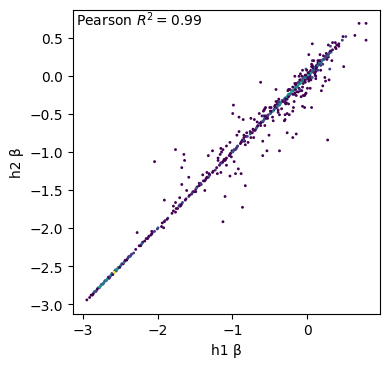

In [106]:
plt.figure(figsize=(4, 7))


plt.subplot(211)
plt.hexbin(model.φ["h1"].β, model.φ["h2"].β, bins="log", gridsize=200)
r = scipy.stats.pearsonr(model.φ["h1"].β, model.φ["h2"].β).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
             fontsize=10,
             xy=(0.01, 0.95), xycoords="axes fraction")
# plt.axvline(0, color="black", linestyle="--", lw=1, zorder=0)
# plt.axhline(0, color="black", linestyle="--", lw=1, zorder=0)
plt.xlabel("h1 β")
plt.ylabel("h2 β")

plt.tight_layout()
plt.show()

In [107]:
model.α

{'h1': Array(5.86830818, dtype=float64),
 'h2': Array(4.85117484, dtype=float64)}

Distribution of $\beta$

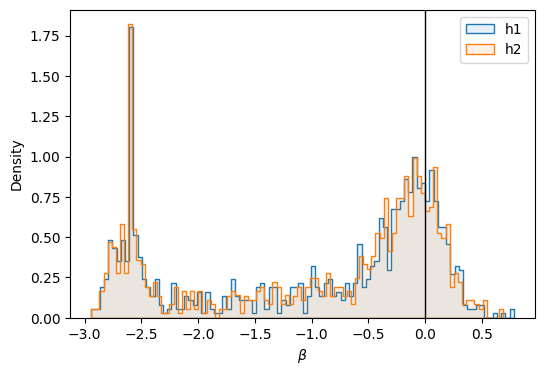

In [108]:
plt.figure(figsize=(6, 4))
for d in model.φ:
    sns.histplot(x=model.φ[d].β, label=d, bins=100, element="step", fill=True, alpha=0.1, stat="density")
plt.axvline(0, color="black", linestyle="-", lw=1)
plt.xlabel(r"$\beta$")
plt.legend()
plt.show()

Compile parameters into dataframe

In [109]:
mutations_df = multidms_data.mutations_df
mutations_df

,mutation,wts,sites,muts,times_seen_h1,times_seen_h2,beta_h1,shift_h1,beta_h2,shift_h2
0,G1A,G,1,A,17,25,-0.862986,0.0,-0.848641,0.014345
1,G1C,G,1,C,10,14,-2.749321,0.0,-2.749321,0.000000
2,G1D,G,1,D,6,9,-0.018582,0.0,-0.018582,0.000000
3,G1E,G,1,E,14,26,-1.700101,0.0,-1.700101,0.000000
4,G1F,G,1,F,11,15,-0.240016,0.0,-0.240016,0.000000
...,...,...,...,...,...,...,...,...,...,...
994,G50S,G,50,S,30,43,-0.589193,0.0,-0.593636,-0.004443
995,G50T,G,50,T,13,23,0.080646,0.0,0.080646,0.000000
996,G50V,G,50,V,19,24,-0.527284,0.0,-0.527284,0.000000
997,G50Y,G,50,Y,12,19,-2.528151,0.0,-2.528151,0.000000


In [110]:
len(multidms_data.mutations), data_sets["h1"].X.shape

(999, (5844, 999))

In [111]:
for d in multidms_data.conditions:
    # add betas to mut dataframe
    mutations_df[f"beta_{d}"] = model.φ[d].β
    # add shifts to mut dataframe
    if d != multidms_data.reference:
        mutations_df[f"shift_{d}"] = model.φ[d].β - model.φ[multidms_data.reference].β

# mutations_df.to_csv(f"{output_dir}/mutations_df.csv", index=False)
mutations_df = (
    mutations_df
    .drop(["wts", "sites", "muts"], axis=1)
    .set_index("mutation")
)
mutations_df

,times_seen_h1,times_seen_h2,beta_h1,shift_h1,beta_h2,shift_h2
mutation,,,,,,
G1A,17,25,-0.862986,0.0,-0.848641,0.014345
G1C,10,14,-2.749321,0.0,-2.749321,0.000000
G1D,6,9,-0.018582,0.0,-0.018582,0.000000
G1E,14,26,-1.700101,0.0,-1.700101,0.000000
G1F,11,15,-0.240016,0.0,-0.240016,0.000000
...,...,...,...,...,...,...
G50S,30,43,-0.589193,0.0,-0.593636,-0.004443
G50T,13,23,0.080646,0.0,0.080646,0.000000
G50V,19,24,-0.527284,0.0,-0.527284,0.000000


In [112]:
simu_mut_effects = (
    simu_mut_effects
    .drop(["wt_aa", "site", "mut_aa"], axis=1)
    .set_index("mutation")
    .rename(
        columns={
            "shift": "simulated_shift",
            "beta_h1": "simulated_beta_h1",
            "beta_h2": "simulated_beta_h2"
        }
    )
)
simu_mut_effects

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut
mutation,,,,,,,
G1A,-2.981264,False,0.0,-2.981264,G,G,False
G1C,-5.609745,False,0.0,-5.609745,G,G,False
G1D,-0.751102,False,0.0,-0.751102,G,G,False
G1E,-5.157105,False,0.0,-5.157105,G,G,False
G1F,-1.019324,False,0.0,-1.019324,G,G,False
...,...,...,...,...,...,...,...
G50T,1.934619,False,0.0,1.934619,G,G,False
G50V,-1.888492,False,0.0,-1.888492,G,G,False
G50W,1.070726,False,0.0,1.070726,G,G,False


In [113]:
set(simu_mut_effects.index.values) - set(mutations_df.index.values)

{'G50W'}

In [114]:
# merge the simulated mut effects with the inferred mut effects
merged_df = simu_mut_effects.join(mutations_df, how="inner")
merged_df

,simulated_beta_h1,shifted_site,simulated_shift,simulated_beta_h2,wt_aa_h1,wt_aa_h2,bundle_mut,times_seen_h1,times_seen_h2,beta_h1,shift_h1,beta_h2,shift_h2
mutation,,,,,,,,,,,,,
G1A,-2.981264,False,0.0,-2.981264,G,G,False,17,25,-0.862986,0.0,-0.848641,0.014345
G1C,-5.609745,False,0.0,-5.609745,G,G,False,10,14,-2.749321,0.0,-2.749321,0.000000
G1D,-0.751102,False,0.0,-0.751102,G,G,False,6,9,-0.018582,0.0,-0.018582,0.000000
G1E,-5.157105,False,0.0,-5.157105,G,G,False,14,26,-1.700101,0.0,-1.700101,0.000000
G1F,-1.019324,False,0.0,-1.019324,G,G,False,11,15,-0.240016,0.0,-0.240016,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
G50S,-3.134911,False,0.0,-3.134911,G,G,False,30,43,-0.589193,0.0,-0.593636,-0.004443
G50T,1.934619,False,0.0,1.934619,G,G,False,13,23,0.080646,0.0,0.080646,0.000000
G50V,-1.888492,False,0.0,-1.888492,G,G,False,19,24,-0.527284,0.0,-0.527284,0.000000


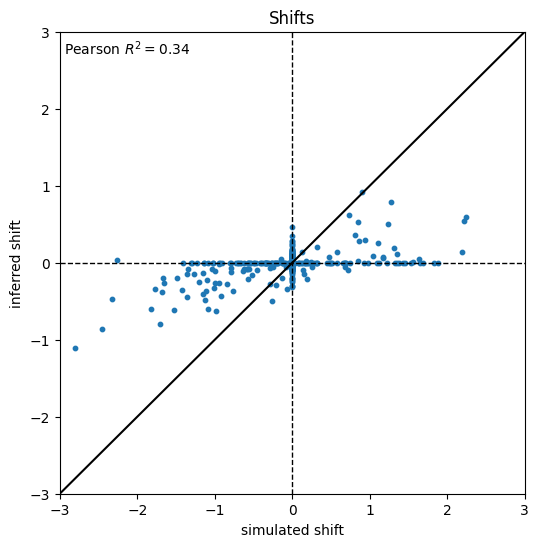

In [117]:
# plot inferred shifts vs simulated shifts for h2
plt.figure(figsize=(6, 6))
x = merged_df["simulated_shift"]
y = merged_df["shift_h2"]
plt.scatter(x, y, alpha=1, s=10)
r = scipy.stats.pearsonr(x, y).statistic
plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                fontsize=10,
                xy=(0.01, 0.95), xycoords="axes fraction")
plt.plot([-3, 3], [-3, 3], "k")
plt.axhline(0, color="k", linestyle="--", lw=1)
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("simulated shift")
plt.ylabel("inferred shift")
plt.title("Shifts")
plt.show()

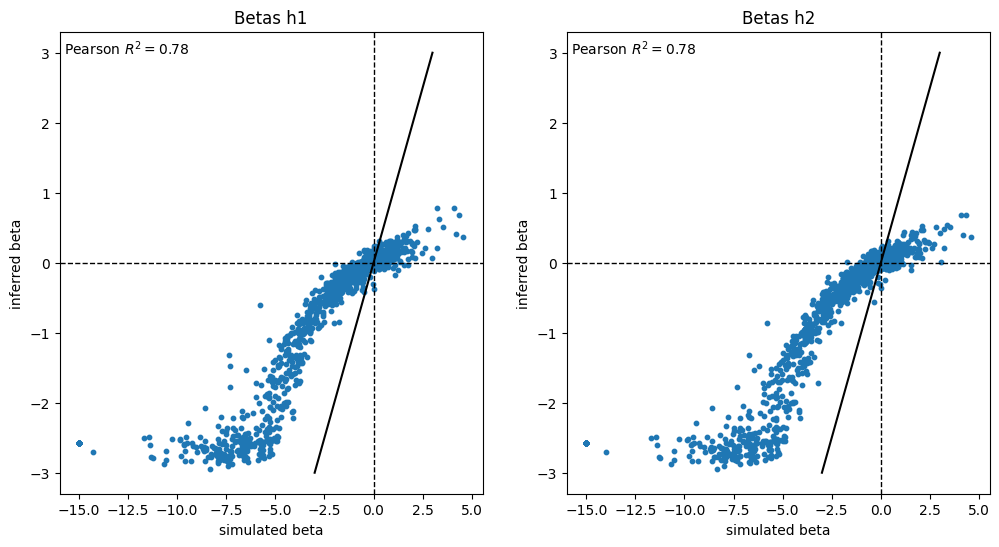

In [119]:
# plot inferred betas vs simulated betas for both h1 and h2
plt.figure(figsize=(12, 6))
for i, d in enumerate(["h1", "h2"]):
    plt.subplot(1, 2, i + 1)
    x = merged_df[f"simulated_beta_{d}"]
    y = merged_df[f"beta_{d}"]
    plt.scatter(x, y, alpha=1, s=10)
    r = scipy.stats.pearsonr(x, y).statistic
    plt.annotate(f"Pearson $R^2={r**2:.2f}$",
                 fontsize=10,
                 xy=(0.01, 0.95), xycoords="axes fraction")
    plt.plot([-3, 3], [-3, 3], "k")
    plt.axhline(0, color="k", linestyle="--", lw=1)
    plt.axvline(0, color="k", linestyle="--", lw=1)
    # plt.xlim(-3, 3)
    # plt.ylim(-3, 3)
    plt.xlabel("simulated beta")
    plt.ylabel("inferred beta")
    plt.title(f"Betas {d}")